I intend to use the MIMIC-IV critical care database to develop a machine learning model that predicts whether a patient discharged from the ICU is likely to be readmitted within 30 days during the same hospital stay.
In addition to standard predictive modeling, I will incorporate uncertainty quantification techniques to estimate the confidence of each prediction, ensuring that the model not only provides an outcome but also a measure of reliability. This is important for clinical decision support, where the trustworthiness of a prediction can influence real-world use. The project will also use SHAP analysis to interpret which features most influence model predictions.
The work will be carried out as an independent research project for skill development in healthcare data science and will not involve any interaction with human subjects.


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [44]:
df=pd.read_csv("/content/icu_readm_data.csv")
# df["readmitted_within_30_days"].value_counts(normalize=True)
# len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21911 entries, 0 to 21910
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject_id       21911 non-null  int64  
 1   hadm_id          21911 non-null  int64  
 2   stay_id          21911 non-null  int64  
 3   gender           21911 non-null  object 
 4   age              21911 non-null  int64  
 5   los_icu_days     21908 non-null  float64
 6   apsiii           21911 non-null  int64  
 7   cci              21911 non-null  int64  
 8   glucose_mean     10475 non-null  float64
 9   creatinine_mean  21865 non-null  float64
 10  platelets_mean   21861 non-null  float64
 11  albumin_mean     14585 non-null  float64
 12  readmit_30d      21911 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 2.2+ MB


In [45]:
df.head()

,subject_id,hadm_id,stay_id,gender,age,los_icu_days,apsiii,cci,glucose_mean,creatinine_mean,platelets_mean,albumin_mean,readmit_30d
0,10368426,21588639,39194905,M,90,0.021725,24,6,NaN,0.850000,266.888889,2.700000,1
1,13333927,26254763,31699045,F,96,14.080509,31,5,176.000000,0.981013,241.757576,2.500000,1
2,17243269,28279412,37310192,F,93,1.251343,20,5,NaN,0.884615,134.181818,3.200000,1
3,17295976,29633749,33539374,M,32,0.148264,21,0,152.333333,0.452727,304.386555,3.292308,1
4,10266364,26629087,30803171,F,31,0.767801,31,1,NaN,0.700000,388.000000,4.300000,0


subject_id → unique patient ID (same patient may have multiple admissions)

hadm_id → unique hospital admission ID (each hospital stay)

stay_id → unique ICU stay ID (a patient can have multiple ICU stays in one hospital admission)

age → patient’s age  (in years)

gender → M/F

race → patient’s self-reported race

language → primary language

marital_status → single/married/etc.

los_hospital → length of stay in hospital (in days)

los_icu → length of stay in ICU in days

hospital_expire_flag → 1 if patient died during hospital stay, 0 if alive

first_hosp_stay → True/False — whether this was their first hospital stay in MIMIC record

first_icu_stay → True/False — whether this was their first ICU stay in MIMIC record

cci=comorbidity_score → Charlson Comorbidity Index (higher = more severe comorbidities)

admittime → hospital admission date/time

dischtime → hospital discharge date/time
(For patient privacy, the admit and discharge dates in the MIMIC datset are shifted by a random offset for each patient.
The offsets preserve temporal consistency within a patient..so their admit/discharge order makes sense, but they don’t correspond to real-world years.)

readmitted_within_30_days → target variable (1 = yes, 0 = no)

main_diagnosis → grouped first diagnosis category (cardiovascular, respiratory, etc.)

In [46]:
df["glucose_mean"].nunique()
df1=df.copy()

In [47]:
df1.drop(columns=["subject_id","hadm_id","glucose_mean"], inplace=True)
df1.info()
# Reason: Glucose mean has about 52% missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21911 entries, 0 to 21910
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          21911 non-null  int64  
 1   gender           21911 non-null  object 
 2   age              21911 non-null  int64  
 3   los_icu_days     21908 non-null  float64
 4   apsiii           21911 non-null  int64  
 5   cci              21911 non-null  int64  
 6   creatinine_mean  21865 non-null  float64
 7   platelets_mean   21861 non-null  float64
 8   albumin_mean     14585 non-null  float64
 9   readmit_30d      21911 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.7+ MB


In [48]:
df1.describe()


,stay_id,age,los_icu_days,apsiii,cci,creatinine_mean,platelets_mean,albumin_mean,readmit_30d
count,2.191100e+04,21911.000000,21908.000000,21911.000000,21911.000000,21865.000000,21861.000000,14585.000000,21911.000000
mean,3.497604e+07,65.082242,3.880032,44.623340,5.258683,1.410423,221.815107,3.083011,0.414632
std,2.871215e+06,16.234402,5.879536,20.121927,3.049192,1.355944,108.704303,0.631530,0.492670
min,3.000015e+07,18.000000,0.001447,0.000000,0.000000,0.100000,5.555556,0.600000,0.000000
25%,3.249397e+07,55.000000,1.117668,30.000000,3.000000,0.712500,151.657895,2.626667,0.000000
50%,3.498466e+07,67.000000,2.047749,41.000000,5.000000,0.961538,208.000000,3.080000,0.000000
75%,3.744628e+07,77.000000,4.164349,55.000000,7.000000,1.512000,275.300000,3.500000,1.000000
max,3.999929e+07,103.000000,226.403079,178.000000,19.000000,24.400000,1393.428571,5.400000,1.000000


In [49]:
# df1.fillna(columns=).median()
for col in ["los_icu_days", "creatinine_mean", "platelets_mean", "albumin_mean"]:
    df1[col]=df1[col].fillna(df1[col].median())
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21911 entries, 0 to 21910
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          21911 non-null  int64  
 1   gender           21911 non-null  object 
 2   age              21911 non-null  int64  
 3   los_icu_days     21911 non-null  float64
 4   apsiii           21911 non-null  int64  
 5   cci              21911 non-null  int64  
 6   creatinine_mean  21911 non-null  float64
 7   platelets_mean   21911 non-null  float64
 8   albumin_mean     21911 non-null  float64
 9   readmit_30d      21911 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.7+ MB


We used "Unknown" instead of "Others" to avoid misleading the model into thinking those cases are actually a fifth legitimate marital status.

In [50]:
df1["readmit_30d"].value_counts()
df1.duplicated().sum()

np.int64(0)

In [51]:
df1.head()

,stay_id,gender,age,los_icu_days,apsiii,cci,creatinine_mean,platelets_mean,albumin_mean,readmit_30d
0,39194905,M,90,0.021725,24,6,0.850000,266.888889,2.700000,1
1,31699045,F,96,14.080509,31,5,0.981013,241.757576,2.500000,1
2,37310192,F,93,1.251343,20,5,0.884615,134.181818,3.200000,1
3,33539374,M,32,0.148264,21,0,0.452727,304.386555,3.292308,1
4,30803171,F,31,0.767801,31,1,0.700000,388.000000,4.300000,0


EXPLORATORY DATA ANALYSIS

1. ***LOS_ICU***

<Axes: ylabel='los_icu_days'>

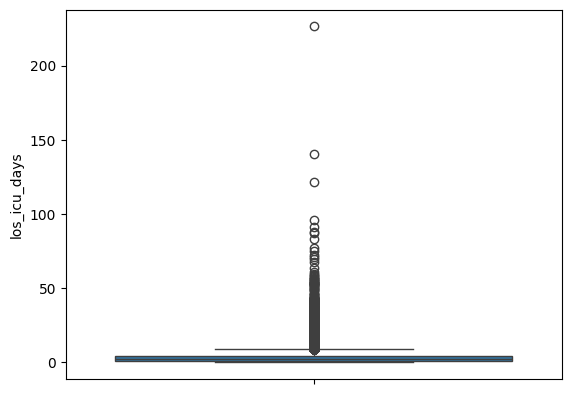

In [52]:
sns.boxplot(df1["los_icu_days"])
# df1["los_icu_days"].sort_values(ascending=False).head(50)

<Axes: xlabel='los_icu_days', ylabel='Count'>

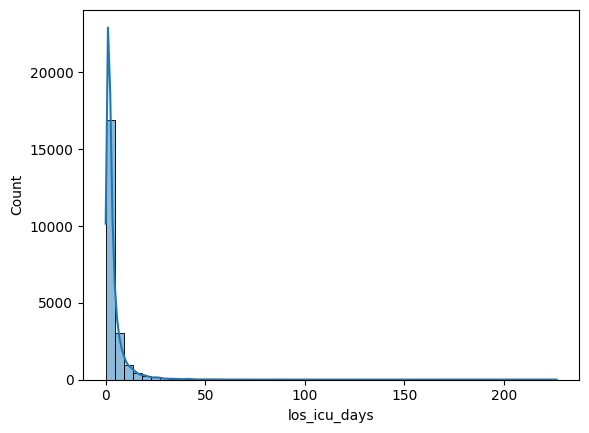

In [53]:
sns.histplot(df1['los_icu_days'], bins=50, kde=True)

Visualization To Detect outliers, multicollinearity

From what we can see here, the los_icu feature is heavily skewed with lots of outliers and this can mislead our model.
Therefore, our approach towards this is to get the logarithm

<Axes: xlabel='los_icu_log', ylabel='Count'>

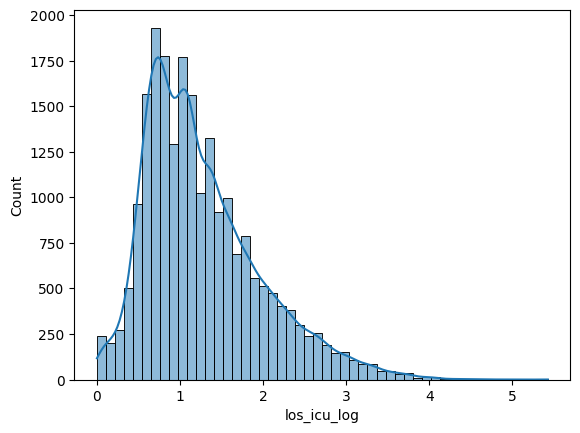

In [58]:
# upper_limit=df["los_icu_days"].quantile(0.01)
# lower_limit=df["los_icu_days"].quantile(0.99)
# df1["los_icu_days"]=np.where(df1["los_icu_days"]>upper_limit, upper_limit, np.where(df1["los_icu_days"]<lower_limit, lower_limit, df1["los_icu_days"]))
# df1["los_icu_days"].sort_values(ascending=False).head(50)
df1["los_icu_log"]=np.log1p(df1["los_icu_days"])
df1.head()
# df1["los_icu_log"].min()
sns.histplot(df1["los_icu_log"], bins=50, kde=True)

***2. APSII(Acute Physiology Score III) ***
This is a severity-of-illness score computed from vital signs and lab values in the first 24hours of ICU admission.
Higher APSIII means sicker patient which means higher mortality/readmission risk.

Text(0.5, 1.0, 'Distribution of aspiii plot')

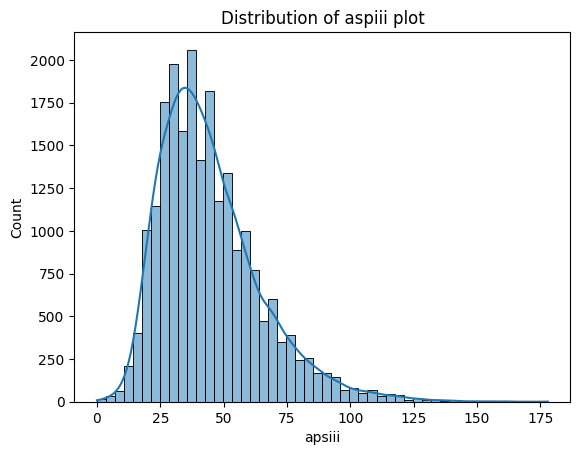

In [71]:
df1["apsiii"].describe()
sns.histplot(df1["apsiii"], bins=50, kde=True)
plt.title("Distribution of aspiii plot")
# df1["apsiii"].corr(df1["readmit_30d"])

Text(0.5, 1.0, 'APSIII vs Readmission (30 Days)')

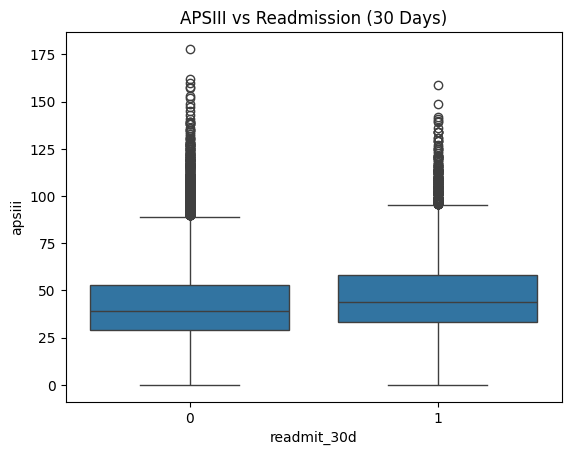

In [80]:
sns.boxplot(x='readmit_30d', y='apsiii', data=df1)
plt.title("APSIII vs Readmission (30 Days)")

3. ***CCI (Charlson comorbidity index)***
***This basically shows the number of associated illnesses the patient has***

<Axes: ylabel='cci'>

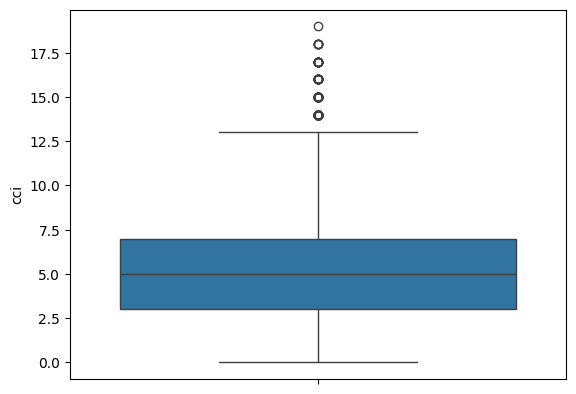

In [78]:
df1["cci"].describe()
df1["cci"].corr(df1["readmit_30d"])
sns.boxplot(df["cci"])

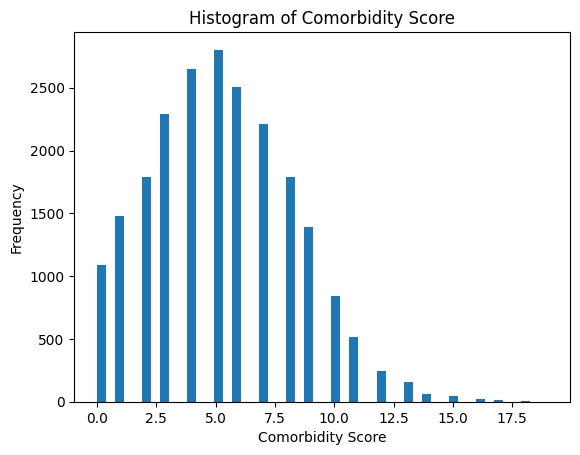

In [70]:
plt.hist(df1["cci"], bins=50)
plt.xlabel("Comorbidity Score")
plt.ylabel("Frequency")
plt.title("Histogram of Comorbidity Score")
plt.show()


4. Creatinine_mean , platelets_mean, albumin_mean    

In [83]:
df1[["creatinine_mean", "platelets_mean", "albumin_mean"]].describe()

,creatinine_mean,platelets_mean,albumin_mean
count,21911.000000,21911.000000,21911.000000
mean,1.409480,221.783581,3.082005
std,1.354675,108.582198,0.515243
min,0.100000,5.555556,0.600000
25%,0.712588,151.818182,2.871429
50%,0.961538,208.000000,3.080000
75%,1.509463,275.142857,3.296667
max,24.400000,1393.428571,5.400000


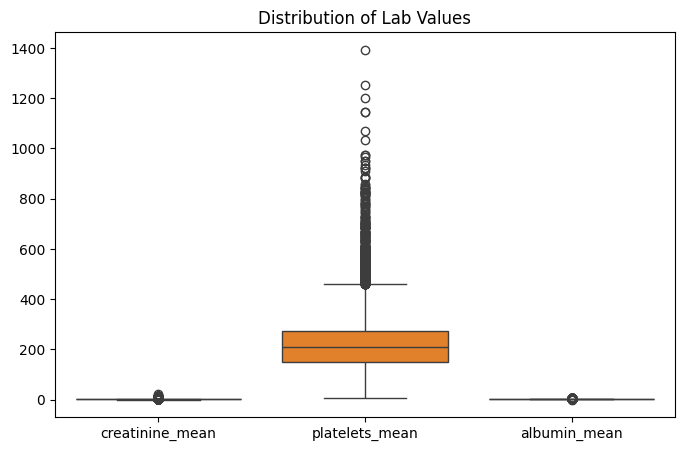

In [84]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df1[["creatinine_mean", "platelets_mean", "albumin_mean"]])
plt.title("Distribution of Lab Values")
plt.show()

In [86]:
df1["platelets_mean"].sort_values(ascending=False).head(30)

,platelets_mean
3920,1393.428571
8673,1254.500000
11240,1202.187500
4220,1146.238095
4139,1146.238095
9275,1070.037037
179,1032.690476
11514,974.777778
12893,973.588235
17839,968.000000


Platelets_mean has a whole lot of outlier values. Through research, i have fpund that the biologically feasible platelet count is  150, 000 to 450, 000 platelets per microliter of blood but ours has velues above 600 and less than even 30

In [87]:
print((df1["platelets_mean"] < 30).sum(), "below 30")
print((df1["platelets_mean"] > 600).sum(), "above 600")


175 below 30
133 above 600


In [88]:
df1 = df1[(df1["platelets_mean"] >= 30) & (df1["platelets_mean"] <= 600)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21603 entries, 0 to 21910
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          21603 non-null  int64  
 1   gender           21603 non-null  object 
 2   age              21603 non-null  int64  
 3   los_icu_days     21603 non-null  float64
 4   apsiii           21603 non-null  int64  
 5   cci              21603 non-null  int64  
 6   creatinine_mean  21603 non-null  float64
 7   platelets_mean   21603 non-null  float64
 8   albumin_mean     21603 non-null  float64
 9   readmit_30d      21603 non-null  int64  
 10  los_icu_log      21603 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 2.0+ MB


In [89]:
df["readmit_30d"].value_counts()

,count
readmit_30d,
0,12826
1,9085


In [91]:
df1.to_csv("cleaned_mimic_data.csv", index=False)